# Data Exploration

## Setup

### Downloading Librabies

In [8]:
%pip install pandas
%pip install spacy
%pip install nltk
%pip install scikit-learn
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl (5.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 2.0.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to

### Importing Librabies

In [1]:
import pandas as pd
import re

## Reading Data

### Read Transactional Data and Non statistical exploration

Reading data and renaming columns as well as dropping uneeded columns

In [49]:
transactional_data = pd.read_csv("../DataSets/TransactionalData/Synthetic_Financial_datasets_log.csv")

transactional_data['nameOrig'] = transactional_data['nameOrig'].str[:4]
transactional_data['nameDest'] = transactional_data['nameDest'].apply(lambda x: x[:3] if x.startswith('M') else x)

print("Fraud: " + str(len(transactional_data[transactional_data['isFraud'] == 1])) + "; Not Fraud: " + str(len(transactional_data[transactional_data['isFraud'] == 0])) + "; Flagged Fraud: " + str(len(transactional_data[transactional_data['isFlaggedFraud'] == 1])))

user_transaction_count = transactional_data.groupby('nameOrig').size().reset_index(name='transaction_count')

transactional_data.loc[transactional_data['nameDest'].str.startswith('C'), 'nameDest'] = 'user'

unique_users_count = transactional_data['nameOrig'].nunique()
unique_merch_count = transactional_data['nameDest'].nunique()

print(f'Total distinct users: {unique_users_count}')
print(f'Total distinct merch: {unique_merch_count}')


# Sort by the number of transactions in descending order
sorted_users = user_transaction_count.sort_values(by='transaction_count', ascending=False)

top_10_users = sorted_users.head(10)
print(top_10_users)

transactional_data = transactional_data[transactional_data['type'] != 'CASH_IN']
#del transactional_data['newbalanceDest']



# Assuming your simulation starts at a specific date and time
start_datetime = '2023-01-01 00:00:00'  # Replace with your actual start date and time
steps = transactional_data['step'].max()  # Total simulation steps (hours)

# Create a date range for the number of steps, incrementing by 1 hour
date_range = pd.date_range(start=start_datetime, periods=steps, freq='1d')

# Total number of records
total_records = len(transactional_data)


# Assign datetime based on the step
transactional_data['transaction_date'] = transactional_data['step'].apply(lambda x: date_range[x-1])

# Display the first few rows of the DataFrame
print(transactional_data['type'].unique())

print(len(transactional_data))

Fraud: 8213; Not Fraud: 6354407; Flagged Fraud: 16
Total distinct users: 900
Total distinct merch: 91
    nameOrig  transaction_count
96      C196              33344
104     C204              33278
59      C159              33248
16      C116              33231
36      C136              33228
101     C201              33225
90      C190              33211
41      C141              33192
44      C144              33163
31      C131              33162
['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT']
4963336


Insure all the data is in correct format for exploration

In [16]:
import numpy as np
chars_to_remove = [' ', ',']

for char in chars_to_remove:
    transactional_data['amount'] = transactional_data['amount'].replace(char, '', regex=True)
    transactional_data['oldbalanceOrg'] = transactional_data['oldbalanceOrg'].replace(char, '', regex=True)
    transactional_data['newbalanceOrig'] = transactional_data['newbalanceOrig'].replace(char, '', regex=True)

transactional_data['amount'] = transactional_data['amount'].astype(np.float32)
transactional_data['oldbalanceOrg'] = transactional_data['oldbalanceOrg'].astype(np.float32)
transactional_data['newbalanceOrig'] = transactional_data['newbalanceOrig'].astype(np.float32)

sorted_data = data = transactional_data.sort_values(by=['nameOrig', 'transaction_date'])

In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

df = transactional_data[transactional_data['isFraud'] == 0]

# Calculate 10% of the original size
sample_size = int(len(df) * 0.1)

# Sample 10% of the data
df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)

# Step 4: Convert `transaction_date` to datetime and extract day, month, and day of week as features
df.loc[:, 'transaction_date'] = pd.to_datetime(df['transaction_date'], format='%d-%b-%y')
df.loc[:, 'day_of_week'] = df['transaction_date'].dt.dayofweek  # Monday=0, Sunday=6
df.loc[:, 'month'] = df['transaction_date'].dt.month

# Step 5: Encode categorical variables (transaction_type and merchant)
le_merchant = LabelEncoder()
df.loc[:, 'nameDest'] = le_merchant.fit_transform(df['nameDest'].values)

le_transaction_type = LabelEncoder()
df.loc[:, 'type'] = le_transaction_type.fit_transform(df['type'].values)

print(df[['amount', 'oldbalanceOrg', 'newbalanceOrig']])
standard_scaler = StandardScaler()
df[['amount', 'oldbalanceOrg', 'newbalanceOrig']] = standard_scaler.fit_transform(df[['amount', 'oldbalanceOrg', 'newbalanceOrig']])

print(df[['amount', 'oldbalanceOrg', 'newbalanceOrig']])
print(df[['amount', 'oldbalanceOrg', 'newbalanceOrig']].dtypes)
print(df[['amount', 'oldbalanceOrg', 'newbalanceOrig']].isna().sum())

# Step 3: Prepare data for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

# Select features for LSTM
features = df[['amount', 'nameDest', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'type', 'step']].values
SEQ_LENGTH = 12
X = create_sequences(features, SEQ_LENGTH)

# Verify the shapes of the output
print("Shape of X (sequences):", X.shape)


           amount  oldbalanceOrg  newbalanceOrig
0          267.09        5005.00         4737.91
1         4338.11         373.00            0.00
2         1738.48           0.00            0.00
3         7568.73           0.00            0.00
4        38594.01       68592.76        29998.74
...           ...            ...             ...
495507  780742.25           0.00            0.00
495508   15176.71       95919.48        80742.77
495509   18792.09       11540.00            0.00
495510   17010.99       40263.00        23252.01
495511   24539.41           0.00            0.00

[495512 rows x 3 columns]
          amount  oldbalanceOrg  newbalanceOrig
0      -0.258795      -0.284488       -0.195414
1      -0.252983      -0.311188       -0.224715
2      -0.256694      -0.313338       -0.224715
3      -0.248370      -0.313338       -0.224715
4      -0.204075       0.082053       -0.039193
...          ...            ...             ...
495507  0.855516      -0.313338       -0.224715
4

In [53]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def create_lstm_autoencoder(timesteps, n_features, latent_dim=64):
    # Input layer
    inputs = Input(shape=(timesteps, n_features))

    # Encoder with optimized architecture
    encoded = LSTM(256, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(inputs)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.3)(encoded)
    encoded = LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.3)(encoded)
    encoded = LSTM(64, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.001))(encoded)
    encoded = BatchNormalization()(encoded)

    # Latent space representation
    latent = Dense(latent_dim, activation='tanh')(encoded)

    # Decoder with optimized architecture
    decoded = RepeatVector(timesteps)(latent)
    decoded = LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.3)(decoded)
    decoded = LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.3)(decoded)
    decoded = LSTM(256, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001))(decoded)

    # Output layer
    output = TimeDistributed(Dense(n_features))(decoded)

    # Full autoencoder model
    autoencoder = Model(inputs, output)
    return autoencoder

In [ ]:
# Instantiate and compile the model
latent_dim = 64
global_autoencoder = create_lstm_autoencoder(SEQ_LENGTH, X.shape[2], latent_dim)
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9
)

# Compile with Adam and learning rate scheduler
global_autoencoder.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mae')

# Optionally add Early Stopping for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# If using a Pandas DataFrame, convert the DataFrame to a NumPy array and ensure numeric types
X = X.astype(np.float32)

# Assuming 'global_transaction_data' is the dataset for general training (preprocesse
# Train the global model
histogram_global = global_autoencoder.fit(X, X, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
15127/24775 ━━━━━━━━━━━━━━━━━━━━ 6:39 41ms/step - loss: 26.9431

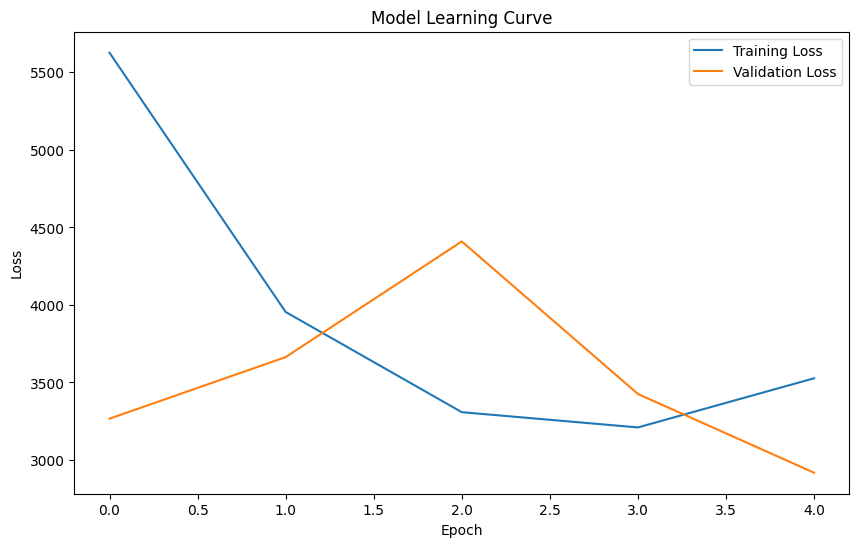

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(histogram_global.history['loss'], label='Training Loss')
plt.plot(histogram_global.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Learning Curve')
plt.legend()
plt.show()

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow import keras
from keras import layers

# Load your DataFrame here (e.g., df = pd.read_csv('your_data.csv')) 
df = transactional_data[transactional_data['isFraud'] == 0]

# Step 1: TF-IDF Vectorization for transaction details
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Step 2: Handle missing values

# Step 3: Convert `transaction_date` to datetime and extract features
df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%d-%b-%y')
df['day_of_week'] = df['transaction_date'].dt.dayofweek  # Monday=0, Sunday=6
df['month'] = df['transaction_date'].dt.month

# Step 4: Encode categorical variables
le_merchant = LabelEncoder()
df['nameDest'] = le_merchant.fit_transform(df['nameDest'])

le_transaction_type = LabelEncoder()
df['type'] = le_transaction_type.fit_transform(df['type'])

# Step 5: Combine features into a single dataset
features = ['type', 'amount', 'oldbalanceOrg', 'day_of_week', 'month', 'nameDest', 'isFlaggedFraud', 'isFlaggedFraud' ]
X = df[features].values  # Convert to NumPy array
#X_tfidf = tfidf_df.values  # Convert TF-IDF DataFrame to NumPy array
#X_combined = np.hstack((X, X_tfidf))  # Combine features

# Step 6: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Split the data into training and testing sets
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Step 8: Define the Autoencoder model
input_dim = X_train.shape[1]  # This should be 1007
print("Input dimension for Autoencoder:", input_dim)

autoencoder = keras.Sequential([
    layers.Input(shape=(input_dim,)),  # Input layer
    layers.Dense(64, activation='relu'),  # Encoder layer
    layers.Dense(32, activation='relu'),  # Bottleneck layer
    layers.Dense(64, activation='relu'),  # Decoder layer
    layers.Dense(input_dim, activation='sigmoid')  # Output layer
])

# Step 9: Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Step 10: Train the Autoencoder
autoencoder.fit(X_train, X_train, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

# Step 11: Make predictions and calculate reconstruction error
reconstructed = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructed, 2), axis=1)
threshold = np.percentile(mse, 95)  # Define a threshold for anomaly detection

# Step 12: Identify anomalies
anomalies = mse > threshold

# Step 13: Output results
#df_test = pd.DataFrame(X_test, columns=[*features, *tfidf_vectorizer.get_feature_names_out()])
df_test = pd.DataFrame(X_test, columns=[*features])
df_test['mse'] = mse
df_test['anomaly'] = anomalies

print(df_test[['mse', 'anomaly']])

/var/folders/jw/dxpsx41s5xlf3dsmc4b4f4tc0000gn/T/ipykernel_6158/3667925212.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%d-%b-%y')
/var/folders/jw/dxpsx41s5xlf3dsmc4b4f4tc0000gn/T/ipykernel_6158/3667925212.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_week'] = df['transaction_date'].dt.dayofweek  # Monday=0, Sunday=6
/var/folders/jw/dxpsx41s5xlf3dsmc4b4f4tc0000gn/T/ipykernel_6158/3667925212.py:20: SettingWithCo

Input dimension for Autoencoder: 8
Epoch 1/5
285949/285949 ━━━━━━━━━━━━━━━━━━━━ 151s 525us/step - loss: 0.4569 - val_loss: 0.4605
Epoch 2/5
285949/285949 ━━━━━━━━━━━━━━━━━━━━ 157s 550us/step - loss: 0.4569 - val_loss: 0.4604
Epoch 3/5
285949/285949 ━━━━━━━━━━━━━━━━━━━━ 179s 624us/step - loss: 0.4549 - val_loss: 0.4604
Epoch 4/5
285949/285949 ━━━━━━━━━━━━━━━━━━━━ 164s 572us/step - loss: 0.4529 - val_loss: 0.4604
Epoch 5/5
285949/285949 ━━━━━━━━━━━━━━━━━━━━ 157s 550us/step - loss: 0.4552 - val_loss: 0.4604
39716/39716 ━━━━━━━━━━━━━━━━━━━━ 15s 387us/step
              mse  anomaly
0        0.308623    False
1        0.069563    False
2        0.053525    False
3        0.057247    False
4        0.269340    False
...           ...      ...
1270877  0.147428    False
1270878  1.510477     True
1270879  0.419291    False
1270880  0.147625    False
1270881  0.278818    False

[1270882 rows x 2 columns]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

# Step 1: Load the original dataset and fine-tuned user data
# Assuming 'df' is your original dataset and 'user_df' is the DataFrame for the specific user
# Example user_df could be something like:
user_df = df[df['nameOrig'] == 'C1603']

print(len(user_df))
# Step 5: Combine features into a single dataset
features = ['type', 'amount', 'oldbalanceOrg', 'day_of_week', 'month', 'nameDest', 'isFlaggedFraud' ]
user_X = user_df[features].values

# Step 3: Load the trained model

# Step 4: Fine-tune the model on user data
# You can train with a lower learning rate or additional epochs
autoencoder.fit(user_X, user_X, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

# Step 5: Evaluate the fine-tuned model on user data
user_reconstructed = autoencoder.predict(user_X)
user_mse = np.mean(np.power(user_X - user_reconstructed, 2), axis=1)

# Adding MSE to user DataFrame
user_df['mse'] = user_mse
user_df['anomaly'] = user_df['mse'] > threshold  # Set a threshold based on your previous evaluation

# Step 6: Analyze results
print(user_df[['transaction_date', 'mse', 'anomaly']])

In [ ]:
# Function to detect anomalies
def detect_anomalies(data, model, threshold):
    # Scale the input data
    data_scaled = scaler.transform(data)
    # Get reconstructed data
    reconstructed = model.predict(data_scaled)
    # Calculate reconstruction errors
    reconstruction_errors = np.mean(np.square(data_scaled - reconstructed), axis=1)
    
    # Identify anomalies
    anomalies = reconstruction_errors > threshold
    return anomalies, reconstruction_errors

# Set a threshold for anomalies (could be determined based on validation set)
threshold = 0.05  # Adjust this based on your validation results

# Use the global model to detect anomalies in the entire dataset
anomalies_global, reconstruction_errors_global = detect_anomalies(X_scaled, autoencoder, threshold)

# Use the fine-tuned model to detect anomalies in user-specific data
anomalies_user, reconstruction_errors_user = detect_anomalies(X_user_scaled, autoencoder, threshold)

# Add results to the DataFrame for better understanding
df['anomaly_global'] = anomalies_global
df['anomaly_user'] = np.nan  # Placeholder for user-specific anomalies
df.loc[df['user'] == 'user_1', 'anomaly_user'] = anomalies_user

# View the results
print(df.head(10))

exploration of users